In [13]:
import qibo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qibo.noise import IBMQNoiseModel
from scipy.optimize import minimize, minimize_scalar

from qibochem.driver.molecule import Molecule
from qibochem.ansatz import hf_circuit, ucc_circuit
from qibochem.measurement import expectation
from qibochem.ansatz import he_circuit

from qibo.hamiltonians import SymbolicHamiltonian

from qibochem.driver.hamiltonian import fermionic_hamiltonian

from openfermion.transforms import *
from openfermion.transforms import binary_code_transform
from openfermion.transforms import get_fermion_operator
from openfermion.utils import up_then_down

from functools import reduce
from qibo import symbols
from tqdm import tqdm

In [3]:
qibo.set_backend("numpy")

[Qibo 0.2.9|INFO|2024-10-16 17:05:48]: Using numpy backend on /CPU:0


In [229]:
# Declaring Constants
E_HF = -1.1176 
E_FCI = -1.1357 # https://pennylane.ai/qml/demos/tutorial_vqe/
EQ_X = 0.7414 # https://cccbdb.nist.gov/exp2x.asp?casno=1333740
E_HF_STR = r'$E_{HF} = -1.1176$'
E_FCI_STR = r'$E_{FCI} = -1.1357$'

In [4]:
# Helper to block print messages
# In particular, "converged SCF energy..."
from IPython.utils.io import capture_output
def block_print(func):
    def func_wrapper(*args, **kwargs):
        with capture_output():
            value = func(*args, **kwargs)
        return value
    return func_wrapper

## Encoding Hamiltonian

The H2 molecule is built via PySCF in the `h2(x)` function, where `x` is the bond length between the two Hydrogen atoms.
The Hamiltonian is reduced using a Parity Mapper, saving 2 qubits of resource.

In [5]:
@block_print
def h2(x):
    molecule = Molecule([('H', (0, 0, 0)), ('H', (0, 0, x))])
    molecule.run_pyscf()
    return molecule

# https://quantumai.google/openfermion/tutorials/binary_code_transforms
def parity_mapped_hamiltonian(molecule):
    hamiltonian = fermionic_hamiltonian(molecule.oei, molecule.tei, molecule.e_nuc)
    hamiltonian = get_fermion_operator(hamiltonian)
    hamiltonian = binary_code_transform(reorder(hamiltonian,up_then_down), 2*checksum_code(2,1))
    symbolic_ham = sum(
        reduce(lambda x, y: x * y, (getattr(symbols, pauli_op)(qubit) for qubit, pauli_op in pauli_string), coeff)
        # Sums over each individual Pauli string in the QubitOperator
        for operator in hamiltonian.get_operators()
        # .terms gives one operator as a single-item dictionary, e.g. {((1: "X"), (2: "Y")): 0.33}
        for pauli_string, coeff in operator.terms.items()
    )
    return SymbolicHamiltonian(symbolic_ham)

In [6]:
molecule = h2(0.725)
hamiltonian = parity_mapped_hamiltonian(molecule)
print(hamiltonian.form)

-0.320260832428307 + 0.180375247205422*X0*X1 + 0.404214660545788*Z0 + 0.0113468843973003*Z0*Z1 + 0.404214660545788*Z1


## Preparing Ansatz

There are 2 ansatz given below. The first is the Hardware Efficient Ansatz (HEA) where it only uses `RY` and `RZ` rotation gates, as well as `CZ` for qubit entanglement. It avoids the use of `CX` gates as they are known to be inefficient and have lower gate fidelity. While it is relatively short, it has more parameters (4 vs 2) than the second ansatz.

The second ansatz is initialized in the Hartree-Fock (HF) state. Then, the Unitary Coupled Cluster (UCC) circuit, which is a variant of the popular gold standard Coupled Cluster ansatz of quantum chemistry, is appended to it, which allows the ansatz to consider electron excitations when evaluating the molecular energy. However, this ansatz has 4 `CX` gates, which makes it more prone to errors.

In [7]:
nlayers = 1
nqubits = hamiltonian.nqubits
ntheta = 2 * nqubits * nlayers
circuit = he_circuit(2, nlayers)
print(circuit.draw())

q0: ─RY─RZ─o─Z─
q1: ─RY─RZ─Z─o─


In [8]:
ntheta = 2
circuit = hf_circuit(nqubits, molecule.nelec)
circuit += ucc_circuit(nqubits, [0, 1])
print(circuit.draw())

q0: ─X─SDG─H─X─RZ─X─H─S───H─X─RZ─X─H───
q1: ─X─H─────o────o─H─SDG─H─o────o─H─S─


## Measuring Energy Expectation Value

The function evaluates the expected energy given an ansatz circuit, bond length and circuit parameters. It is used as the cost function when performing classical optimization in the next step.

In [9]:
def energy(x, theta, circuit):
    if type(x) != np.float64:
        x, theta = theta, x
        
    molecule = h2(x)
    hamiltonian = parity_mapped_hamiltonian(molecule)
    circuit.set_parameters(theta)
    return expectation(circuit, hamiltonian)

## Classical Optimization

Unlike the standard VQE provided by the library that solves for the ground state given a fixed bond length, the optimization function below solves for both molecular geometry and electronic state at the same time. When consecutive results have a difference lower than `tolerance`, the optimization loop will break.

In [290]:
def optimize(circuit, tolerance: float = 1e-5, max_iter: int = 30, output: bool = False):    
    theta, x = np.random.uniform(0, 2 * np.pi, ntheta), np.float64(1.0)
    cur = prev = energy(x, theta, circuit)
    
    it = 1
    vqe_energy, bond_length = [cur], [x]
    with tqdm(total=0, desc="Optimizing", disable=(not output)) as pbar:
        while it < max_iter:
            result = minimize(energy, theta, args=(x, circuit), method="BFGS", options={'maxiter': 1})
            theta = result.x
            
            result = minimize_scalar(energy, bounds=(0, 2), args=(theta, circuit), options={'maxiter': max(5, it)})
            x = result.x
            
            cur = energy(x, theta, circuit)
            delta = abs(cur - prev)
            
            pbar.set_postfix({
                'E': f"{cur:.6f}",
                'x': f"{x:.6f}",
                'delta': f"{delta:.6f}"
            })
            
            if delta < tolerance:
                break
            
            vqe_energy.append(cur)
            bond_length.append(x)
            prev = cur
            it += 1
            pbar.update(1)

        pbar.close()
        
    return cur, x, vqe_energy, bond_length, it

In [291]:
_, _, vqe_energy, bond_length, it = optimize(circuit, output=True)

Optimizing: 8it [00:03,  2.52it/s, E=-1.137305, x=0.735284, delta=0.000004]


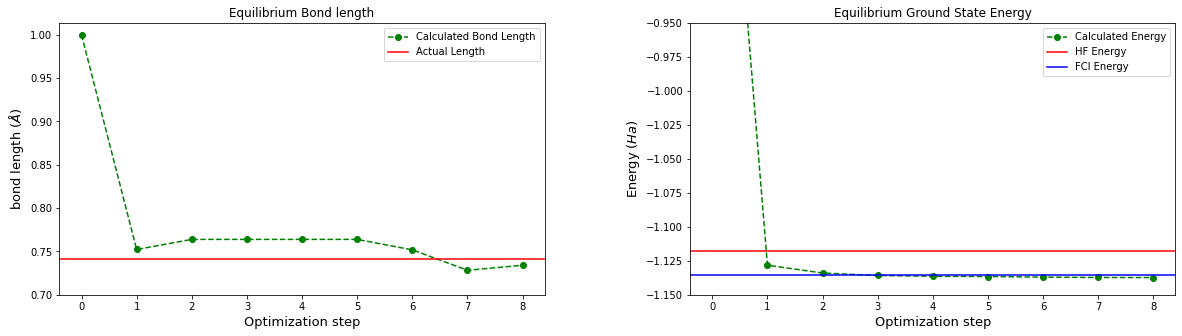

In [292]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, it), bond_length, "go", ls="dashed", label="Calculated Bond Length")
ax1.axhline(y=EQ_X, color='r', label="Actual Length")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("bond length ($\AA$)", fontsize=13)
ax1.title.set_text("Equilibrium Bond length")
ax1.set_ylim(0.70)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, it), vqe_energy, "go", ls="dashed", label="Calculated Energy")
ax2.axhline(y=E_HF, color='r', label="HF Energy")
ax2.axhline(y=E_FCI, color='b', label="FCI Energy")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Energy ($Ha$)", fontsize=13)
ax2.title.set_text("Equilibrium Ground State Energy")
ax2.set_ylim(top=-0.95, bottom=-1.15)
ax2.legend()

plt.subplots_adjust(wspace=0.3)
plt.show()

In [423]:
distances = np.arange(0.2, 3.51, 0.05)
scf_energy, vqe_energy = [], []

for x in tqdm(distances, desc="Calculating energies"):
    molecule = h2(x)
    scf_energy.append(molecule.e_hf)
    
    theta = np.random.uniform(0, 2 * np.pi, ntheta)
    result = minimize(energy, theta, args=(x, circuit), method="BFGS", options={'maxiter': 100})
    vqe_energy.append(result.fun)
    
scf_energy = np.array(scf_energy)
vqe_energy = np.array(vqe_energy)

Calculating energies: 100%|██████████| 67/67 [00:30<00:00,  2.21it/s]


Minimum SCF Energy: -1.11734903499028
Hartree-Fock Energy: -1.1176
Minimum VQE Energy: -1.1371170673457291
FCI Energy: -1.1357


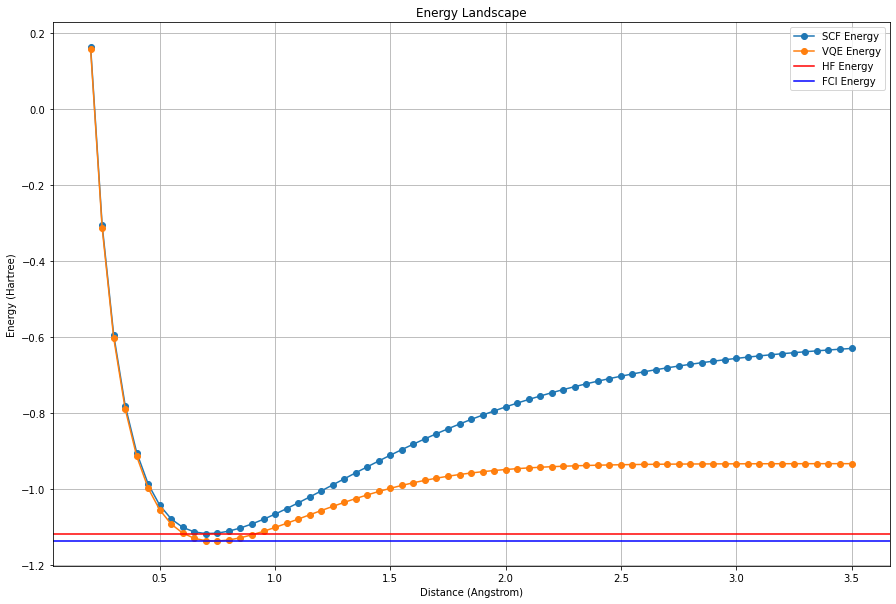

In [433]:
print("Minimum SCF Energy:", scf_energy.min())
print("Hartree-Fock Energy:", E_HF)
print("Minimum VQE Energy:", vqe_energy.min())
print("FCI Energy:", E_FCI)

plt.figure(figsize=(15, 10))
plt.plot(distances, scf_energy, 'o-', label="SCF Energy")
plt.plot(distances, vqe_energy, 'o-', label="VQE Energy")
plt.axhline(y=E_HF, color='r', label="HF Energy")
plt.axhline(y=E_FCI, color='b', label="FCI Energy")
plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Landscape')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
accuracies = np.concatenate((np.logspace(0, 12, num=50, base=1.75)[19:], np.array([1024])))
# accuracies = np.array([1024])
vqe_energies, bond_lengths = [], []
for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
    parameters = {
        "t1": accuracy * 1e-6,
        "t2": accuracy * 0.5e-6,
        "gate_times" : (40e-9, 150e-9),
        "excited_population" : 0,
        "depolarizing_one_qubit" : 0,
        "depolarizing_two_qubit": 0,
        "readout_one_qubit" : {"0": 0, "1": 0},
    }
    
    noise_model = IBMQNoiseModel()
    noise_model.from_dict(parameters)
    noisy_circuit = noise_model.apply(circuit)
    noisy_circuit.density_matrix = True
    
    vqe_energy, x, _, _, _ = optimize(noisy_circuit)
    vqe_energies.append(vqe_energy)
    bond_lengths.append(x)

Evaluating simulation: 100%|██████████| 32/32 [01:47<00:00,  3.35s/it]


In [299]:
for i in range(14, 21):
    accuracies = np.concatenate((np.logspace(0, 12, num=50, base=1.75)[19:], np.array([1024])))
    vqe_energies, bond_lengths = [], []
    for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
        parameters = {
            "t1": accuracy * 1e-6,
            "t2": accuracy * 0.5e-6,
            "gate_times" : (40e-9, 150e-9),
            "excited_population" : 0,
            "depolarizing_one_qubit" : 0,
            "depolarizing_two_qubit": 0,
            "readout_one_qubit" : {"0": 0, "1": 0},
        }
        
        noise_model = IBMQNoiseModel()
        noise_model.from_dict(parameters)
        noisy_circuit = noise_model.apply(circuit)
        noisy_circuit.density_matrix = True
        
        vqe_energy, x, _, _, _ = optimize(noisy_circuit)
        vqe_energies.append(vqe_energy)
        bond_lengths.append(x)
        
    df = pd.read_csv("energy_acc_qibo2.csv")
    df[f"ucc_energy_{i}"] = vqe_energies
    df.to_csv("energy_acc_qibo2.csv", index=False)

Evaluating simulation: 100%|██████████| 32/32 [02:28<00:00,  4.64s/it]


In [371]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def func(x, a, b, c, d, p):
  return (a * np.exp(-b * x)) * np.power(x + c, -d) + p

def fit_noise_curve(accuracies, data):
    params = curve_fit(f=func, xdata=accuracies, ydata=data, p0=(0.5, 0.05, 0.5, 0.5, 0),
                bounds=([0, 0, -1, 0.1, -5], [1, 0.1, 1, 1, 0]), maxfev=10000)[0]
    y_fit = func(accuracies, *params)
    return y_fit, params, r2_score(data, y_fit)

def percentage_error(actual, predicted):
    return 100 * abs((predicted - actual) / actual)

In [388]:
df = pd.read_csv("energy_acc_qibo2.csv")
accuracies = np.concatenate((np.logspace(0, 12, num=50, base=1.75)[19:], np.array([1024])))
vqe_energies = df[[f'ucc_energy_{i}' for i in range(1, 11)]].mean(axis=1)

Parameters: 0.9557741459709536 0.0026956711506606 -0.08010872261084134 0.8003074457849111 -1.1351005894028852
R2 Score: 0.9997101129039099


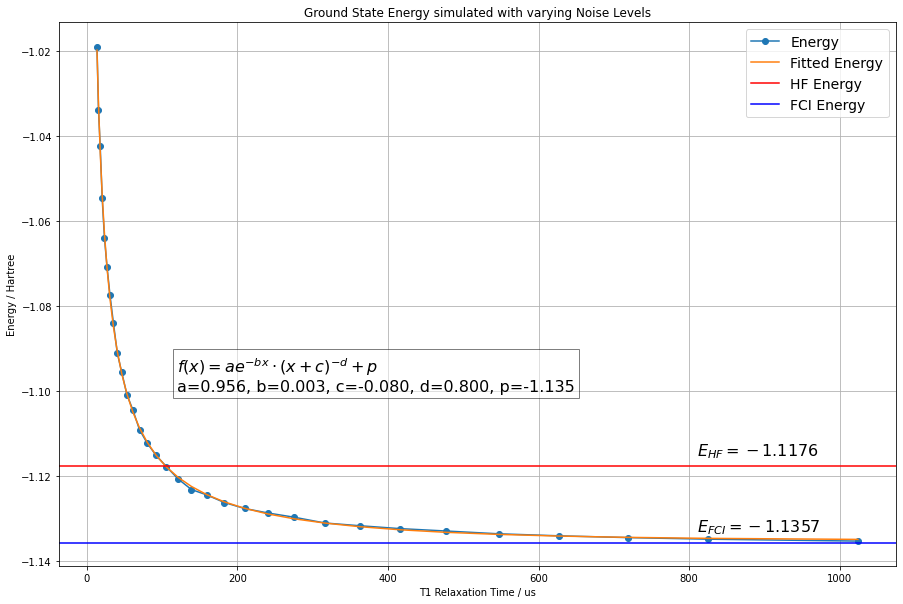

In [389]:
y_fit, params, score = fit_noise_curve(accuracies, vqe_energies)
a, b, c, d, p = params
print("Parameters:", *params)
print("R2 Score:", score)

plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, vqe_energies, 'o-', label="Energy")
plt.plot(accuracies, y_fit, label="Fitted Energy")
equation_text = r'$f(x) = ae^{-bx} \cdot ({x + c})^{-d} + p$'
params_text = f'a={a:.3f}, b={b:.3f}, c={c:.3f}, d={d:.3f}, p={p:.3f}'
plt.text(120, -1.10, equation_text + '\n' + params_text, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.text(810, -1.115, E_HF_STR, fontsize=16)
plt.text(810, -1.133, E_FCI_STR, fontsize=16)
plt.axhline(y=E_HF, color='r', label="HF Energy")
plt.axhline(y=E_FCI, color='b', label="FCI Energy")
plt.title('Ground State Energy simulated with varying Noise Levels')
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

In [406]:
guesses, pred_errors, normal_errors = [], [], []
for limit in range(10, 32):
    _, (_, _, _, _, p), _ = fit_noise_curve(accuracies[:limit], vqe_energies[:limit])
    guesses.append(p)
    pred_error = percentage_error(p, E_FCI)
    normal_error = percentage_error(vqe_energies[limit], E_FCI)
    pred_errors.append(pred_error)
    normal_errors.append(normal_error)
    
guesses = np.array(guesses)

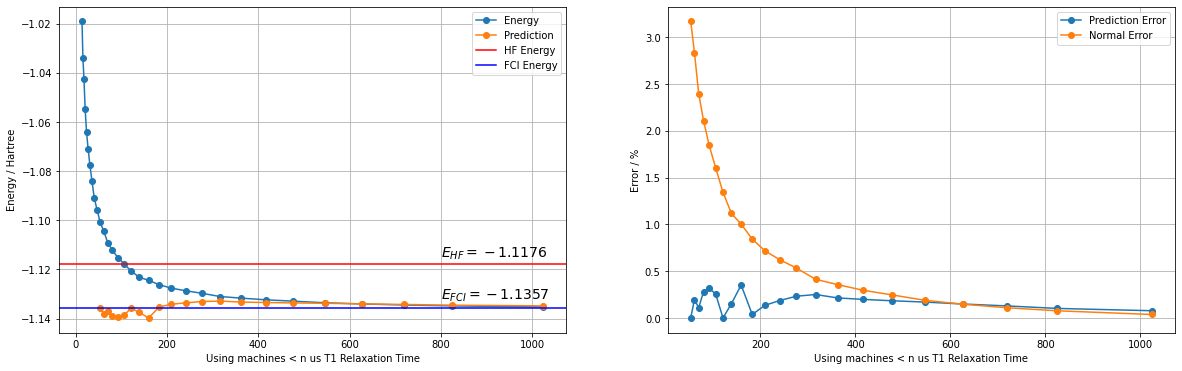

In [422]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1 = fig.add_subplot(121)
ax1.plot(accuracies, vqe_energies, 'o-', label="Energy")
ax1.plot(accuracies[10:], guesses, 'o-', label="Prediction")
ax1.text(800, -1.115, E_HF_STR, fontsize=14)
ax1.text(800, -1.132, E_FCI_STR, fontsize=14)
ax1.axhline(y=E_HF, color='r', label="HF Energy")
ax1.axhline(y=E_FCI, color='b', label="FCI Energy")
ax1.set_xlabel('Using machines < n us T1 Relaxation Time')
ax1.set_ylabel('Energy / Hartree')
ax1.grid(True)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(accuracies[10:], pred_errors, 'o-', label='Prediction Error')
ax2.plot(accuracies[10:], normal_errors, 'o-', label='Normal Error')
ax2.set_xlabel('Using machines < n us T1 Relaxation Time')
ax2.set_ylabel('Error / %')
ax2.grid(True)
ax2.legend()

plt.show()

In [434]:
# Enter the T1 relaxation time of your quantum computers
accuracies = np.array([20, 35, 50, 60, 75, 90, 100])
samples = 5

vqe_energies = []
for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
    res = []
    for _ in range(samples):
        parameters = {
            "t1": accuracy * 1e-6,
            "t2": accuracy * 0.5e-6,
            "gate_times" : (40e-9, 150e-9),
            "excited_population" : 0,
            "depolarizing_one_qubit" : 0,
            "depolarizing_two_qubit": 0,
            "readout_one_qubit" : {"0": 0, "1": 0},
        }
        
        noise_model = IBMQNoiseModel()
        noise_model.from_dict(parameters)
        noisy_circuit = noise_model.apply(circuit)
        noisy_circuit.density_matrix = True
        
        vqe_energy, x, _, _, _ = optimize(noisy_circuit)
        res.append(vqe_energy)
        
    vqe_energies.append(np.array(res).mean())

Evaluating simulation: 100%|██████████| 7/7 [02:33<00:00, 21.88s/it]


T1 Relaxation Times (us):      20         35         50         60         75         90         100       
       VQE Energies (Ha):      -1.05045   -1.08649   -1.09659   -1.10473   -1.11148   -1.11507   -1.1174   

Parameters: [ 9.84770e-01  9.10000e-04 -9.37740e-01  8.14300e-01 -1.13849e+00]
R2 Score: 0.9969867699526966

Extrapolated Energy: -1.13849
Actual Energy (FCI): -1.1357
Predicted Error: 0.24533 %
Normal Error: 1.61172 %


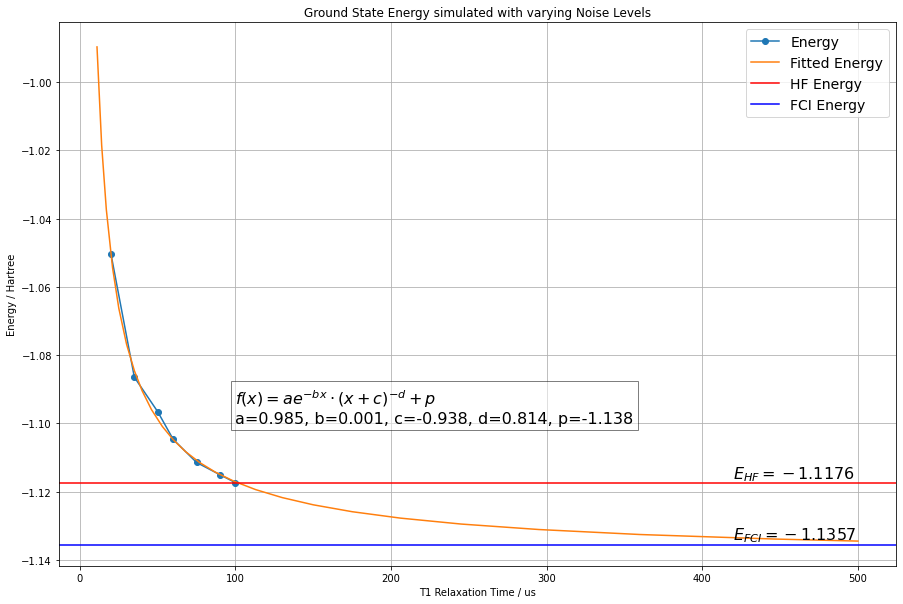

In [458]:
y_fit, params, score = fit_noise_curve(accuracies, vqe_energies)
a, b, c, d, p = params
print("T1 Relaxation Times (us):".ljust(30), ' '.join(list(map(lambda x: f"{np.round(x, 5):<10}", accuracies))))
print("VQE Energies (Ha):".rjust(25).ljust(30), ' '.join(list(map(lambda x: f"{np.round(x, 5):<10}", vqe_energies))))
print()
print("Parameters:", np.round(params, 5))
print("R2 Score:", score)
print()
print("Extrapolated Energy:", np.round(p, 5))
print("Actual Energy (FCI):", E_FCI)
print("Predicted Error:", np.round(abs((p - E_FCI) / E_FCI) * 100, 5), "%")
print("Normal Error:", np.round(abs((vqe_energies[accuracies.argmax()] - E_FCI) / E_FCI) * 100, 5), "%")

test_accuracies = np.arange(11, 501, 1)
test_fit = func(test_accuracies, *params)

plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, vqe_energies, 'o-', label="Energy")
plt.plot(test_accuracies, test_fit, label="Fitted Energy")
equation_text = r'$f(x) = ae^{-bx} \cdot ({x + c})^{-d} + p$'
params_text = f'a={a:.3f}, b={b:.3f}, c={c:.3f}, d={d:.3f}, p={p:.3f}'
plt.text(100, -1.10, equation_text + '\n' + params_text, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.text(420, -1.116, E_HF_STR, fontsize=16)
plt.text(420, -1.134, E_FCI_STR, fontsize=16)
plt.axhline(y=E_HF, color='r', label="HF Energy")
plt.axhline(y=E_FCI, color='b', label="FCI Energy")
plt.title('Ground State Energy simulated with varying Noise Levels')
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend(fontsize=14)
plt.show()